In [13]:
#see notes in blue binder for documents of this. 
#code was tested on three tensors: A-B-C

In [14]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
def get_repeated_Indices(list_of_indices):
    #input: string of indices for the tensors. 
    #output: string of repeated indices. code takes in indices and output only the repeated indices
    #Ex: Suppose tensor A has index ijkp, and tensor B has index klpm.
    #then get_repeated_Indices('ijkp', 'klpm') will return the following string: 'kp'
    myList = list_of_indices
    #convert List to string
    myString =''.join(myList)
    #break the string into indivual list of characters ex.  'abc' ->['a','b', 'c']
    myList = list(myString)
    #get the repeated frequencies of each indices
    my_dict = {i:myList.count(i) for i in myList}
    
    repeatedList = []
    for item in my_dict:
        if my_dict[item] > 1:
            repeatedList.append(item)
    return repeatedList

def  remove_Repeated_indices(List_of_indices):
    #inputs: tensor indices in the form of string
    #output: string of non repeated indicies
    #Ex: remove_Repeated_indices('abc', 'cde')
    #output of the example would be: 'abde'
    
    myList = List_of_indices 
    #turn myList into String: Ex: ['abc','cde'] -> 'abccde'
    myString = ''.join(myList)
    #turn back into lists again: Exp: from 'abccde' -> ['a','b','c','c','d','e']
    myList = list(myString)
    repeated_indices = get_repeated_Indices(List_of_indices)
    #print('the repeated list of indices are:', repeated_indices)
    unique_indices = []
    #now we remove repeated indices from myList
    for item in myList:
        if item not in repeated_indices:
            unique_indices.append(item)
    uniqueString = ''.join(unique_indices)   
    return uniqueString



In [15]:
def einSum_Contraction(tensorList, indxList):  #<----should rename this to einSum_Contraction to replace old code
    #Purpose: this function takes a list of tensors, and list of indices, and indix to contract and uses einstien summation to perform contraction
    #ex: tensorList = [tensor1, tensor2, tensor3]
    #indxList   = [indx1, indx2, indx3]
    myList = []
    uniqueIndices = remove_Repeated_indices(indxList)
    inputIndices = [indxList]
    N = len(indxList)
    #myList = [indx1, ',',indx2,',',indx3,'->', uniqueIndices] 
    for i in range(N - 1):
        myList.append(indxList[i])
        myList.append(',') 
    myList.append(indxList[N-1])
    myList.append('->')
    myList.append(uniqueIndices)
    #convert myList to a string: i.e.  [indx1, ',',indx2,',',indx3,'->', uniqueIndices]  - >'ijk,klm,mjp->ilp'
    myString = ''.join(myList)
    #print('myString = ', myString)
    C = torch.einsum(myString, tensorList)
    return C

In [90]:
def computeLoss(approxTensor, targetTensor):
    cost = torch.norm(approxTensor - targetTensor, 'fro') 
    return(cost)


In [91]:
def padTensor(tensor, pad_axis):
    #this is for the discrete optimization
    #this function takes a tensor and append an extra dimension of ~ zeros along the specified axis (we call the pad axis)
    if pad_axis == -1:
        return tensor #don't pad anything
    tensorShape = list(tensor.shape)
    tensorShape[pad_axis] = 1  #increase the dimension up by 1
    zerosPad = torch.rand(tensorShape) *1e-6  #pad with values approx. equal to zero
    padded_tensor = torch.cat([tensor, zerosPad], pad_axis)
    #print('padded_tensor.shape = ', padded_tensor.shape)
    #print('padded_tensor function output = ', padded_tensor)
    return padded_tensor

In [92]:
def increaseRank(Tensor1, Tensor2, indx1, indx2):
    # The indx 1 and index2 represents the indices for tensor 1 and 2 respectively. 
    #There is only one repeated index in the list (indx1, indx2). The repeated index represents the shared edge between
    #the two tensors. For ex: ijkl, lmno
    alpha = get_repeated_Indices([indx1, indx2])
    #convert alpha to string
    alpha = ''.join(alpha)
    # find the position of the repeated index alpha in indx1 and indx2
    padAxes1 = indx1.index(alpha)
    padAxes2 = indx2.index(alpha)  
    
    paddedTensor1 = padTensor(Tensor1, padAxes1)
    paddedTensor2 = padTensor(Tensor2, padAxes2)
    return  paddedTensor1, paddedTensor2

In [93]:
def solve_Continuous(target_Tensor, tensorList, indxList, iterNum):
#input: list of tensors and their corresponding indices
#Goal: The purpose of this function is to solve the innerloop of the optimization for the problem
    len_Tensor = len(tensorList)
    len_Indx   = len(indxList)
    

    for i in range(len_Tensor):
        tensorList[i] = tensorList[i].detach()
        tensorList[i].requires_grad = True

    #defines a SGD optimizer to update the parameters
    #optimizer = optim.SGD(tensorList lr = 0.001, momentum=0.2)
    optimizer = optim.Adam(tensorList, lr=0.009)

    #initialize parameters      
    LostList = []              #use this to plot the lost function

    for i in range(iterNum):
        optimizer.zero_grad()
        tensor_approx = einSum_Contraction(tensorList, indxList)
        loss_fn = computeLoss(tensor_approx, target_Tensor)
        loss_fn.backward()
        optimizer.step()                # the new A,B,C will be A_k+1,B_k+1, C_k+1 after optimizer.step 
        LostList.append(loss_fn)
    return tensorList, indxList, LostList

In [94]:
def avgPoints(list1, num_points):
    #num_points = number of elements from list1 that you want to take the average of
    n = len(list1)
    avg = sum(list1[n-num_points:n])/num_points
    return avg

In [95]:
#generate target tensor of rank 1
X =  torch.Tensor([[[1]],[[2]]])
Y =  torch.Tensor([[[3],[4],[5]]])
Z =  torch.Tensor([[[6,7,8,9]]])

d1 = 2
d2 = 3
d3 = 4
r1 = 2
r2 = 3
r3 = 2

X = torch.rand(d1, r3, r1)
Y = torch.rand(r1, d2, r2)
Z = torch.rand(r2, r3, d3)
print(X.shape)
print(Y.shape)
print(Z.shape)

indx0 = 'ijk'
indx1 = 'klm'
indx2 = 'mjp'

target_Tensor = einSum_Contraction([X, Y, Z], [indx0, indx1, indx2])
print('shapeTargetTensor=', target_Tensor.shape)



torch.Size([2, 2, 2])
torch.Size([2, 3, 3])
torch.Size([3, 2, 4])
shapeTargetTensor= torch.Size([2, 3, 4])


In [96]:
#initilize
r1 = 1
r2 = 1
r3 = 1
#generate at random target tensor
X_approx0 = torch.rand(d1,r3,r1)*1
X_approx0 = X_approx0/torch.norm(X_approx0, 'fro') 
Y_approx0 = torch.rand(r1,d2,r2)*1
Y_approx0 = Y_approx0/torch.norm(Y_approx0, 'fro') 
Z_approx0 = torch.rand(r2,r3,d3)*1
Z_approx0 = Z_approx0/torch.norm(Z_approx0, 'fro') 

##this intialize tensor close to target tensor. This is to confirm the loss function is low as eplected
#noise = 0.000000000001
#X_approx0 =  torch.Tensor([[[1]],[[2]]]) + torch.rand(2,1,1)*noise  #need to check it is from normal distribution
#Y_approx0 =  torch.Tensor([[[3],[4],[5]]])+ torch.rand(1,3,1)*noise
#Z_approx0 =  torch.Tensor([[[6,7,8,9]]])+ torch.rand(1,1,4)*noise

indx0 = 'ijk'
indx1 = 'kmn'
indx2 = 'njp'
indxList = [indx0, indx1, indx2]

In [99]:
def printRank(TensorList):
    [d1, r3, r1] = (TensorList[0].shape) #tensor X dimension
    [r1, d2, r2] = (TensorList[1].shape) #tensor Y dimension
    print(' [r1, r2, r3] = ', '[', r1, ',', r2, ',', r3, ']')
    return r1,r2,r3

In [101]:
def getNumParams(r1,r2,r3):
    numParam = d1*r1*r3 + r1*d2*r2 + r2*r3*d3
    #print('d1*r1*r3 = ', d1*r1*r3)
    #print('r1*d2*r2', r1*d2*r2)
    #print('r2*r3*d3', r2*r3*d3)
    return numParam

In [102]:
#Here we added a third loop. Each iteration samples a different grid point and its nearby neighbours. It computes the continuous
#opt for different rank combinations and stores the one with the least minimum.
A = X_approx0
B = Y_approx0
C = Z_approx0

indxList = [indx0, indx1, indx2]
TensorList = [A, B, C]
TensorList_temp = [A, B, C] #TensorList[:]
iterNum=500
Lost_star = 5
check = 1
maxParam = d1*d2*d3
numParam = -1
paramKey = -1


for k in range(5):
    if paramKey == 1:
        break
    for i in range(len(TensorList_temp)):
        if paramKey == 1:
            break
        for j in range(i,len(TensorList_temp)):
            if paramKey == 1:
                break
            if i==j:
                continue
            print(i,j)
            #increase the ranks of the tensors
            [TensorList_temp[i],TensorList_temp[j]] = increaseRank(TensorList_temp[i], TensorList_temp[j],  indxList[i], indxList[j])
            
            #check num of paramters for the newly updated ranks
            [r1_t,r2_t,r3_t] = printRank(TensorList_temp)
            numParam_temp = getNumParams(r1_t,r2_t,r3_t)
            print('num of parameters for recently updated ranks= ', numParam_temp)
            if numParam_temp > maxParam:
                paramKey = 1
                print('Max number of parameters exceeded. Current Param = ', numParam_temp, 'and max Param allowed = ', maxParam)
                print('program finish ')
                break
            #solve continuous part
            [TensorList_temp, indxList, LostList] = solve_Continuous(target_Tensor, TensorList_temp, indxList, iterNum)
            print('Currently evaluating rank:')
            printRank(TensorList_temp)
            
            #store the optimal value for a given point around its neighbour
            if Lost_star > LostList[-1]: #avgLost:  #When have time, take the average of 10 elements as opposed to the min. of last elementLostList[-1]:  #When have time, take the average of 10 elements as opposed to the min. of last element
                    indx_star = [i,j]
                    TensorList_star = TensorList_temp[:]
                    indxList_star = indxList[:]
                    print('Lost* updated: Lost_star previous =', Lost_star, 'Lost_star current =', LostList[-1])
                    Lost_star = LostList[-1]  
                    print('current Best rank:')
                    [r1,r2,r3] = printRank(TensorList_star)
                    numParam = getNumParams(r1,r2,r3)
                    #numParam = d1*r1*r3 + r1*d2*r2 + r2*r3*d3
                    #print('d1*r1*r3 = ', d1*r1*r3)
                    #print('r1*d2*r2', r1*d2*r2)
                    #print('r2*r3*d3', r2*r3*d3)
                    print('total number of parameters for best chosen ranks = ', numParam)
                    check = -1
            elif Lost_star <= LostList[-1]:
                print('Prev Loss = ', Lost_star, 'Current Loss = ', LostList[-1])
                print('Loss previous is less than current, so no rank update is made at this iteration')
                print('total number of parameters for best chosen rank = ', numParam)

            
            #Reset TensorList_temp to continue with greedy at another point
            TensorList_temp = TensorList[:] #set back to previous position to continue with greedy search
            print('***************************************************************')  
    print('****************************moving to another grid point ***********************************')
    #update parameters   
    #print('TensorList_star[0] = ', TensorList_star[0])
    #print('TensorList_star[1] = ', TensorList_star[1])
    #print('TensorList_star[2] = ', TensorList_star[2])
    TensorList_temp = TensorList_star[:]    #everything is behaving as expected
    #print('TensorList_temp[0] After = ', TensorList_temp[0])
    #print('TensorList_temp[1] After = ', TensorList_temp[1])
    #print('TensorList_temp[2] After = ', TensorList_temp[2])
    #print('indxList_star[2] before = ', indxList_star[2])
    indxList = indxList_star[:]     # don't really need to update this cause these don't really change
    #print('indxList[2] after = ', indxList[2])
    #print('TensorList_star[0] =',  TensorList_star[0])
    TensorList  = TensorList_star[:]  #everything is behaving as expected
    #print('TensorList[0] =',  TensorList[0])
    

0 1
 [r1, r2, r3] =  [ 2 , 1 , 1 ]
num of parameters for recently updated ranks=  14
Currently evaluating rank:
 [r1, r2, r3] =  [ 2 , 1 , 1 ]
Lost* updated: Lost_star previous = 5 Lost_star current = tensor(0.7328, grad_fn=<NormBackward0>)
current Best rank:
 [r1, r2, r3] =  [ 2 , 1 , 1 ]
total number of parameters for best chosen ranks =  14
***************************************************************
0 2
 [r1, r2, r3] =  [ 1 , 1 , 2 ]
num of parameters for recently updated ranks=  15
Currently evaluating rank:
 [r1, r2, r3] =  [ 1 , 1 , 2 ]
Prev Loss =  tensor(0.7328, grad_fn=<NormBackward0>) Current Loss =  tensor(0.9622, grad_fn=<NormBackward0>)
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  14
***************************************************************
1 2
 [r1, r2, r3] =  [ 1 , 2 , 1 ]
num of parameters for recently updated ranks=  16
Currently evaluating rank:
 [r1, r2, r3] =  [ 1 , 2 , 1

loss function approaches = tensor(0.1092, grad_fn=<NormBackward0>)


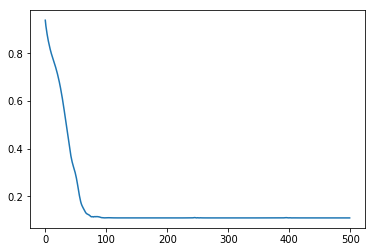

In [103]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure()
plt.plot(LostList)
print('loss function approaches =', LostList[-1])